In [185]:
import folium
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from datetime import datetime
from datetime import date
from IPython.display import HTML
from shapely.geometry import shape, Point

%matplotlib inline

In [119]:
column_names = ['created_at', 'id', 'source', 'lat', 'long', 'text']
activity_my = pd.read_csv('output_city.tmp', header=None, names=column_names) \
             .append(pd.read_csv('output_geo.tmp', header=None, names=column_names)) \
             .drop_duplicates(subset='id') \
             .loc[lambda x: (x.lat >= 52.3216) & (x.lat <= 52.4251) & (x.long >= 4.7685) & (x.long <= 5.0173)]
print(activity_my.shape)
activity_my.head()

(450, 6)


,created_at,id,source,lat,long,text
0,Mon Jun 05 19:56:12 +0000 2017,871817952110284805,twitter,52.373100,4.892200,"Home for now, but I left a little piece of my ..."
1,Mon Jun 05 19:57:02 +0000 2017,871818162291044356,twitter,52.366670,4.900000,Good evening #Amsterdam! Sun will set in 30 mi...
3,Mon Jun 05 19:59:48 +0000 2017,871818861733191680,twitter,52.378300,4.929400,View from my bedroom. #home #amsterdam #ij #ja...
4,Mon Jun 05 20:00:20 +0000 2017,871818994927403008,twitter,52.373100,4.892200,"💌 @ Amsterdam, Netherlands https://t.co/8sdSQ..."
5,Mon Jun 05 20:01:34 +0000 2017,871819306568478721,twitter,52.378193,4.966624,De #schellingwouderbrug in #amsterdam ging zoj...


In [120]:
activity_roman = pd.read_csv('amsterdam_tweets_loc.txt', delimiter=' ', header=None)
activity_roman.columns = ['long', 'lat', 'id', 'hz', 'weekday', 'month', 'day', 'time', 'hz3', 'year']
activity_roman['created_at'] = activity_roman['weekday'].map(str) + ' ' + \
                               activity_roman['month'].map(str) + ' 0' + \
                               activity_roman['day'].map(str) + ' ' + \
                               activity_roman['time'].map(str) + ' +0000 ' + \
                               activity_roman['year'].map(str)
activity_roman['source'] = 'roman'
activity_roman = activity_roman.drop(['hz', 'weekday', 'month', 'day', 'time', 'hz3', 'year'], 1)
activity_roman.head()

,long,lat,id,created_at,source
0,4.657549,52.484567,871886868991934464,Tue Jun 06 00:30:03 +0000 2017,roman
1,4.895168,52.370216,871887886160986112,Tue Jun 06 00:34:05 +0000 2017,roman
2,4.892200,52.373100,871888196287819778,Tue Jun 06 00:35:19 +0000 2017,roman
3,4.940486,52.366862,871889682434588672,Tue Jun 06 00:41:13 +0000 2017,roman
4,4.927100,52.328000,871890648235995136,Tue Jun 06 00:45:04 +0000 2017,roman


In [147]:
activity = activity_my.append(activity_roman).drop_duplicates(subset='id').set_index(['id'])
#     .drop_duplicates(subset='id')
activity['created'] = activity.apply( \
    lambda x: datetime.strptime(x['created_at'], '%a %b %d %H:%M:%S +%f %Y'), axis=1)
activity.head()
# activity[activity.index.duplicated()]

,created_at,lat,long,source,text,created
id,,,,,,
871817952110284805,Mon Jun 05 19:56:12 +0000 2017,52.373100,4.892200,twitter,"Home for now, but I left a little piece of my ...",2017-06-05 19:56:12
871818162291044356,Mon Jun 05 19:57:02 +0000 2017,52.366670,4.900000,twitter,Good evening #Amsterdam! Sun will set in 30 mi...,2017-06-05 19:57:02
871818861733191680,Mon Jun 05 19:59:48 +0000 2017,52.378300,4.929400,twitter,View from my bedroom. #home #amsterdam #ij #ja...,2017-06-05 19:59:48
871818994927403008,Mon Jun 05 20:00:20 +0000 2017,52.373100,4.892200,twitter,"💌 @ Amsterdam, Netherlands https://t.co/8sdSQ...",2017-06-05 20:00:20
871819306568478721,Mon Jun 05 20:01:34 +0000 2017,52.378193,4.966624,twitter,De #schellingwouderbrug in #amsterdam ging zoj...,2017-06-05 20:01:34


(1264, 6)
0.00   2017-06-05 19:56:12.000
0.25   2017-06-06 07:50:04.500
0.50   2017-06-06 12:50:39.000
0.75   2017-06-06 17:00:27.000
1.00   2017-06-06 22:11:02.000
Name: created, dtype: datetime64[ns]


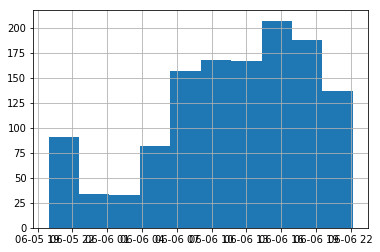

In [162]:
print(activity.shape)
print(activity.created.astype('int64').quantile([0, .25, .5, .75, 1]).astype('datetime64[ns]'))
activity.created.sort_values().hist()

In [183]:
with open('amsterdam.geojson') as f:
    geojson = json.load(f)

polygons = [(feature['properties']['name'], shape(feature['geometry'])) for feature in geojson['features']]

regions = [''] * activity.shape[0]
for i in range(activity.shape[0]):
    point = Point(activity.iloc[i]['long'], activity.iloc[i]['lat'])
    for name, polygon in polygons:
        if polygon.contains(point):
            regions[i] = name
            break

activity = activity.assign(region = regions)

In [184]:
activity

,created_at,lat,long,source,text,created,region
id,,,,,,,
871817952110284805,Mon Jun 05 19:56:12 +0000 2017,52.373100,4.892200,twitter,"Home for now, but I left a little piece of my ...",2017-06-05 19:56:12,Burgwallen-Nieuwe Zijde
871818162291044356,Mon Jun 05 19:57:02 +0000 2017,52.366670,4.900000,twitter,Good evening #Amsterdam! Sun will set in 30 mi...,2017-06-05 19:57:02,Grachtengordel-Zuid
871818861733191680,Mon Jun 05 19:59:48 +0000 2017,52.378300,4.929400,twitter,View from my bedroom. #home #amsterdam #ij #ja...,2017-06-05 19:59:48,Oostelijk Havengebied
871818994927403008,Mon Jun 05 20:00:20 +0000 2017,52.373100,4.892200,twitter,"💌 @ Amsterdam, Netherlands https://t.co/8sdSQ...",2017-06-05 20:00:20,Burgwallen-Nieuwe Zijde
871819306568478721,Mon Jun 05 20:01:34 +0000 2017,52.378193,4.966624,twitter,De #schellingwouderbrug in #amsterdam ging zoj...,2017-06-05 20:01:34,
871819404786360322,Mon Jun 05 20:01:58 +0000 2017,52.362231,4.883822,twitter,#snarkypuppy #paradiso #amsterdam @ Paradiso A...,2017-06-05 20:01:58,De Weteringschans
871819724254064649,Mon Jun 05 20:03:14 +0000 2017,52.362732,4.884545,twitter,"I'm at Castell in Amsterdam, Noord-Holland htt...",2017-06-05 20:03:14,De Weteringschans
871820078672695296,Mon Jun 05 20:04:39 +0000 2017,52.343643,4.886686,twitter,KUNST RAI ART AMSTERDAM #art🎨 #artlovers #rai...,2017-06-05 20:04:39,Scheldebuurt
871820319887159296,Mon Jun 05 20:05:36 +0000 2017,52.378193,4.966624,twitter,De #schellingwouderbrug in #amsterdam is weer ...,2017-06-05 20:05:36,


In [109]:
region_popularity = activity.region.value_counts().to_frame()
region_popularity.columns = ['count']
region_popularity['region'] = region_popularity.index
region_popularity.dtypes

count      int64
region    object
dtype: object

In [193]:
def create_map(df):
    map = folium.Map(location=[52.3702, 4.8952], zoom_start=11)

# for index, row in activity.iterrows():
#     folium.Marker([row['lat'], row['long']]).add_to(map)

# folium.GeoJson(open('amsterdam.geojson'),
#                name='geojson'
#               ).add_to(map)
# folium.LayerControl().add_to(map)

# map.choropleth(geo_path='amsterdam.geojson')

    region_popularity = df.region.value_counts().to_frame()
    region_popularity.columns = ['count']
    region_popularity['region'] = region_popularity.index
    region_popularity.dtypes

    map.choropleth(geo_path='amsterdam.geojson', data=region_popularity,
                 columns=['region', 'count'],
                 key_on='feature.properties.name',
                 fill_color='BuPu', fill_opacity=0.7, line_opacity=0.7,
                 legend_name='Tweets count')

    return map

In [197]:
map = create_map(activity)
map

In [210]:
regexp = re.compile(r'\d+\.\d+')
waste = pd.read_csv('mor-afval-1.csv', delimiter=';')
waste['long'] = waste.apply(lambda x: float(regexp.findall(x['locatie'])[0]), axis=1)
waste['lat'] = waste.apply(lambda x: float(regexp.findall(x['locatie'])[1]), axis=1)

waste['created'] = waste.apply( \
    lambda x: datetime.strptime(x['datum'], '%Y-%m-%d %H:%M:%S'), axis=1)

regions = [''] * waste.shape[0]
for i in range(waste.shape[0]):
    point = Point(waste.iloc[i]['long'], waste.iloc[i]['lat'])
    for name, polygon in polygons:
        if polygon.contains(point):
            regions[i] = name
            break

waste = waste.assign(region = regions)

In [212]:
waste
# [waste.Subrubriek == 'Grofvuil']

waste[['lat', 'long', 'region', 'Subrubriek', 'created']].head()

# create_map(waste)
# create_map(waste[waste['Subrubriek'] == 'Veeg- / zwerfvuil'])
# waste

,lat,long,region,Subrubriek,created
0,52.362728,4.793433,Osdorp-Midden,Puin / sloopafval,2015-09-21
1,52.390671,4.791810,Bedrijventerrein Sloterdijk,Grofvuil,2016-12-28
2,52.368389,4.779056,Lutkemeer en Ookmeer,Grofvuil,2017-02-14
3,52.366530,4.802485,Lutkemeer en Ookmeer,Puin / sloopafval,2016-09-14
4,52.358129,4.803051,Osdorp-Oost,Puin / sloopafval,2016-12-11


In [213]:
regexp = re.compile(r'\d+\.\d+')
nuisance = pd.read_csv('mor-openbare-ruimte-en-overlast.csv', delimiter=';')

nuisance['long'] = nuisance.apply(lambda x: float(regexp.findall(x['locatie'])[0]), axis=1)
nuisance['lat'] = nuisance.apply(lambda x: float(regexp.findall(x['locatie'])[1]), axis=1)

nuisance['created'] = nuisance.apply( \
    lambda x: datetime.strptime(x['datum'], '%Y-%m-%d %H:%M:%S'), axis=1)

regions = [''] * nuisance.shape[0]
for i in range(nuisance.shape[0]):
    point = Point(nuisance.iloc[i]['long'], nuisance.iloc[i]['lat'])
    for name, polygon in polygons:
        if polygon.contains(point):
            regions[i] = name
            break

nuisance = nuisance.assign(region = regions)



,titel,titel_key,online_tijdsaspect,categorie,externe_id,datum,adres,postcode,omschrijving,locatie,...,Categorie_nummer,Categorie_status,Datum,Status,Subrubriek,categorie_2,id_2,opmerking,title,url
0,MORA-0604728,mora_0604728_1,1,276,NaN,2016-01-11 00:00:00,Lutkemeerweg 194,NaN,NaN,POINT (4.7699980394 52.3619156474),...,9172,Openbare ruimte & overlast - In behandeling,11-01-2016,In behandeling,"Onderhoud stoep, straat en fietspad",9172,point_3478774,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0604728,http://www.opdekaart.amsterdam.nl/mor/items/mo...
1,MORA-0847246,mora_0847246_1,1,276,NaN,2016-10-05 00:00:00,Ookmeerweg 501,NaN,NaN,POINT (4.76952799118 52.3545521733),...,9172,Openbare ruimte & overlast - In behandeling,05-10-2016,In behandeling,Verkeersoverlast / Verkeerssituaties,9172,point_3630453,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0847246,http://www.opdekaart.amsterdam.nl/mor/items/mo...
2,MORA-0907626,mora_0907626_1,1,276,NaN,2016-12-08 00:00:00,Lutkemeerweg 220,NaN,NaN,POINT (4.76834296634 52.361637372),...,9172,Openbare ruimte & overlast - In behandeling,08-12-2016,In behandeling,"Onderhoud stoep, straat en fietspad",9172,point_3655830,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0907626,http://www.opdekaart.amsterdam.nl/mor/items/mo...
3,MORA-0240023,mora_0240023_1,1,276,NaN,2014-10-15 00:00:00,Pyrenee�n 1,NaN,NaN,POINT (4.77343888168 52.3498449217),...,9172,Openbare ruimte & overlast - In behandeling,15-10-2014,In behandeling,Brug,9172,point_3289953,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0240023,http://www.opdekaart.amsterdam.nl/mor/items/mo...
4,MORA-0505639,mora_0505639,1,276,NaN,2015-09-15 00:00:00,La Meye 12,NaN,NaN,POINT (4.77252011183 52.3525994166),...,9172,Openbare ruimte & overlast - In behandeling,15-09-2015,In behandeling,Put / riolering verstopt,9172,point_3436112,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0505639,http://www.opdekaart.amsterdam.nl/mor/items/mo...
5,MORA-0334386,mora_0334386_1,1,276,NaN,2015-02-17 00:00:00,Langswater 392,NaN,NaN,POINT (4.78966465762 52.3558149705),...,9172,Openbare ruimte & overlast - In behandeling,17-02-2015,In behandeling,Overig,9172,point_3355698,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0334386,http://www.opdekaart.amsterdam.nl/mor/items/mo...
6,MORA-0228350,mora_0228350_1,1,276,NaN,2014-09-29 00:00:00,Dijkgraafplein 1,NaN,NaN,POINT (4.78754157429 52.3554177579),...,9172,Openbare ruimte & overlast - Nieuw,29-09-2014,Nieuw,"Onderhoud stoep, straat en fietspad",9172,point_3286445,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0228350,http://www.opdekaart.amsterdam.nl/mor/items/mo...
7,MORA-0153306,mora_0153306_1,1,276,NaN,2014-06-05 00:00:00,Rijsdrechthof 10,NaN,NaN,POINT (4.78508074261 52.3561153022),...,9172,Openbare ruimte & overlast - In behandeling,05-06-2014,In behandeling,"Verkeersbord, verkeersafzetting",9172,point_3198838,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0153306,http://www.opdekaart.amsterdam.nl/mor/items/mo...
8,MORA-0201157,mora_0201157_1,1,276,NaN,2014-08-21 00:00:00,Brisselkerkstraat 10,NaN,NaN,POINT (4.79485606913 52.3583846118),...,9172,Openbare ruimte & overlast - In behandeling,21-08-2014,In behandeling,"Onderhoud stoep, straat en fietspad",9172,point_3277607,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0201157,http://www.opdekaart.amsterdam.nl/mor/items/mo...
9,MORA-0201164,mora_0201164_1,1,276,NaN,2014-08-21 00:00:00,Borrendammehof 1,NaN,NaN,POINT (4.793796549 52.3585770366),...,9172,Openbare ruimte & overlast - In behandeling,21-08-2014,In behandeling,"Onderhoud stoep, straat en fietspad",9172,point_3277452,Deze melding wordt ��n keer per dag om 09.00 u...,MORA-0201164,http://www.opdekaart.amsterdam.nl/mor/items/mo...
